In [1]:
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, select_columns, reshape_dataset, fillna_dataset
from ipynb.fs.defs.Feature_Expansion_Module import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.Neural_Network_Module import Dataset, transformations, FeedforwardNeuralNetModel, train_nn
from ipynb.fs.defs.Model_Validation_Module import validation_plots, metrics, eucleidian
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# set the only_env as True if you want to use only environmental features
only_env = True
# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'mosquito_regression'
# set the transform argument as True if you want to limit the target variable to 0-9 scale
transform_target = False
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the transformation actions of the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = ['scaling']

In [3]:
data = read_data('../Datasets/Italy/Veneto/Culex/IT_veneto_culex_2010_2023.csv')
#=====================================================================
data = data[data.trap_type != 'Gravid Trap']
data = data.reset_index(drop=True)
#=====================================================================
columns = ['x', 'y', 'dt_placement',
           'culex.spp', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean' ]
names = ['x', 'y', 'dt_placement',
         'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/Italy_veneto_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/Italy_veneto_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['station_id', 'x', 'y', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex.spp',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_minus_7_avail

In [4]:
data = feature_expansion(data, env=only_env)

In [5]:
data = initializer(data, model_type, dropna=True)

In [6]:
test = data.sample(frac = 0.20, random_state=0)
train = data.drop(data.index[list(test.index)]).reset_index(drop=True)
test = test.reset_index(drop=True)

In [7]:
#define a nn 
model = FeedforwardNeuralNetModel(num_features=len(train.iloc[0,:])-2, num_class=1, encode_layers = [512,360,256,128,64],
                                  decode_layers = [64,128,256,360,512], latent_dim=5, dropout=[0.3,0.3,0,0,0],
                                  model_type=model_type, learning_rate = 0.001, epochs = 100, batch_size = 128,
                                  transformation_list = transformation_list, early_stop = None)

In [8]:
#preprocess nn input
del train[date_col]
date = test[date_col]
del test[date_col]

train_X, train_y, test_X, test_y = transformations(train, test = test, model_type = model.model_type, 
                                                   embedding_data = model.embedding_data,
                                                   transformation_list = model.transformation_list)

training_set = Dataset(train_X, train_y)

testing_set = Dataset(test_X, test_y)

Epoch 001: | Train Loss: 69738.93776 | Val Loss: 145550.71842 | Train Acc: 149.191| Val Acc: 165.694
Epoch 002: | Train Loss: 68743.77526 | Val Loss: 144745.71989 | Train Acc: 147.933| Val Acc: 164.858
Epoch 003: | Train Loss: 67772.64497 | Val Loss: 143771.06445 | Train Acc: 146.986| Val Acc: 164.346
Epoch 004: | Train Loss: 66859.13238 | Val Loss: 141163.29883 | Train Acc: 145.781| Val Acc: 162.098
Epoch 005: | Train Loss: 65780.39184 | Val Loss: 140497.91390 | Train Acc: 144.401| Val Acc: 161.784
Epoch 006: | Train Loss: 64535.04531 | Val Loss: 138477.65885 | Train Acc: 142.983| Val Acc: 159.802
Epoch 007: | Train Loss: 63046.56493 | Val Loss: 136137.09928 | Train Acc: 141.113| Val Acc: 157.257
Epoch 008: | Train Loss: 61394.50616 | Val Loss: 134586.03141 | Train Acc: 139.160| Val Acc: 156.426
Epoch 009: | Train Loss: 59752.14983 | Val Loss: 132195.17253 | Train Acc: 137.164| Val Acc: 154.879
Epoch 010: | Train Loss: 57930.65842 | Val Loss: 131159.25798 | Train Acc: 134.868| Val Acc

Epoch 084: | Train Loss: 6426.28213 | Val Loss: 71318.80998 | Train Acc: 51.462| Val Acc: 112.000
Epoch 085: | Train Loss: 5735.39511 | Val Loss: 69013.56755 | Train Acc: 49.689| Val Acc: 111.500
Epoch 086: | Train Loss: 5630.19751 | Val Loss: 69259.57300 | Train Acc: 49.584| Val Acc: 111.395
Epoch 087: | Train Loss: 5756.70220 | Val Loss: 68705.32869 | Train Acc: 49.388| Val Acc: 111.839
Epoch 088: | Train Loss: 5652.34394 | Val Loss: 68403.10872 | Train Acc: 49.276| Val Acc: 111.421
Epoch 089: | Train Loss: 5786.92592 | Val Loss: 68424.59578 | Train Acc: 49.625| Val Acc: 111.691
Epoch 090: | Train Loss: 5834.02458 | Val Loss: 68210.23145 | Train Acc: 50.227| Val Acc: 112.816
Epoch 091: | Train Loss: 5735.29053 | Val Loss: 71177.76514 | Train Acc: 49.607| Val Acc: 112.123
Epoch 092: | Train Loss: 5578.30398 | Val Loss: 70216.80111 | Train Acc: 48.736| Val Acc: 113.273
Epoch 093: | Train Loss: 5672.20900 | Val Loss: 68505.72184 | Train Acc: 49.343| Val Acc: 112.161
Epoch 094: | Train L

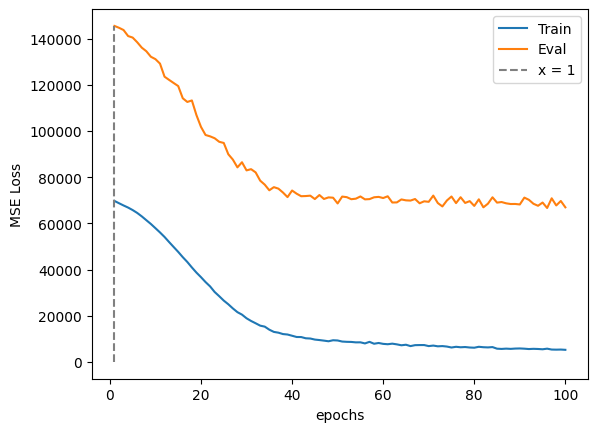

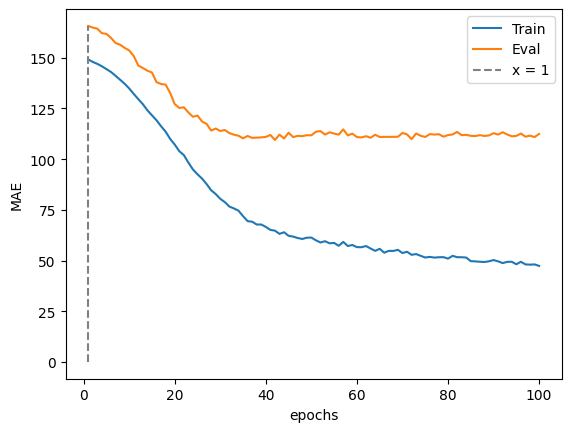

In [9]:
#train_nn
results_train, results_test, latent_train, latent_test, _ = train_nn(model = model, train_set = training_set,
                                                                     test_set = testing_set, features=None, max_val = train_y.max())

MAE on train set:  38.40094836670179
min prediction: 1
max prediction: 804

MAE on test set:  116.29515108924807
Error <= 30: 47.08 %
min prediction: 1
max prediction: 804


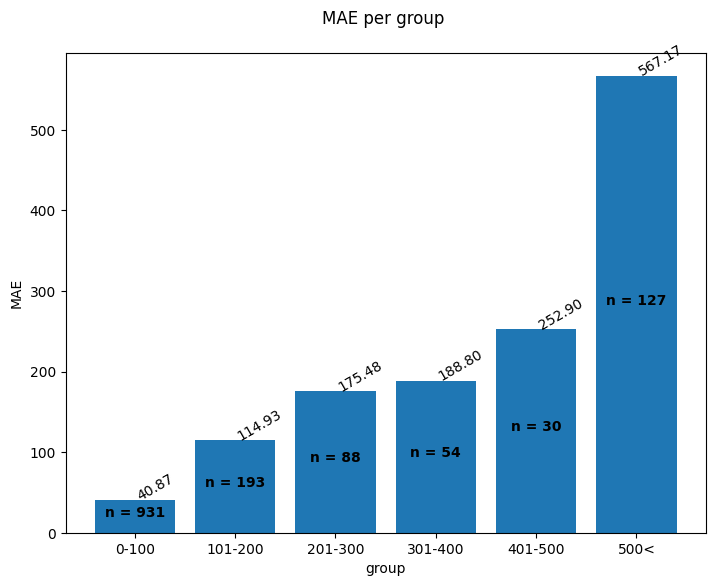

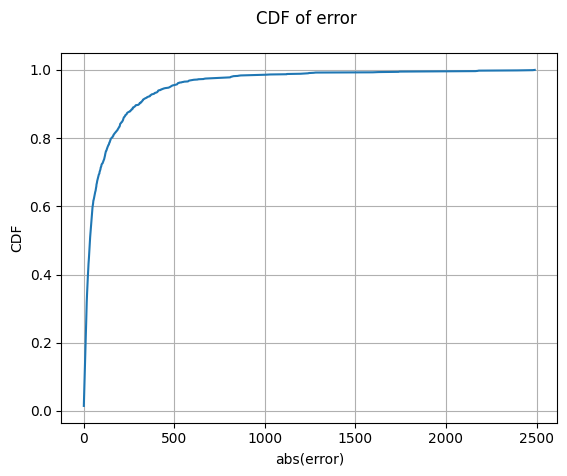

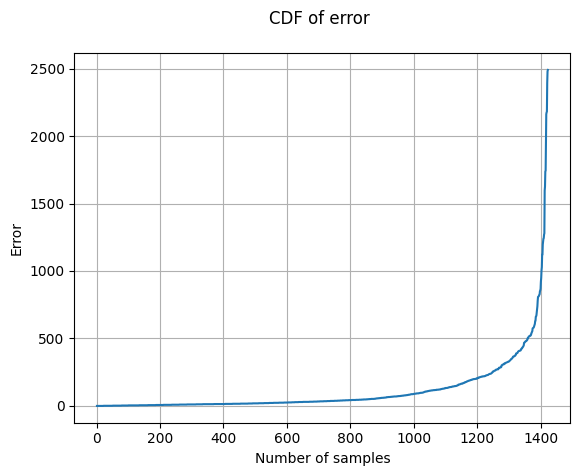

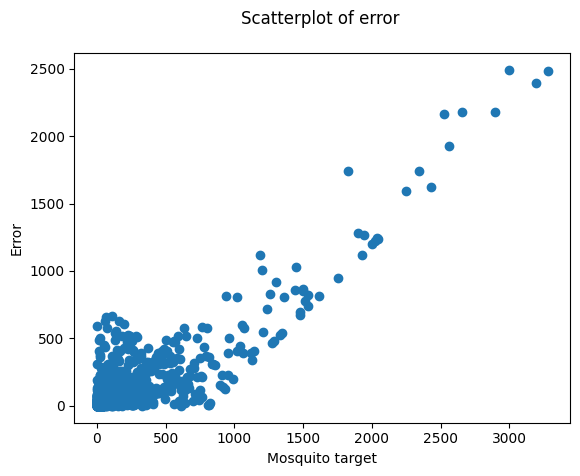

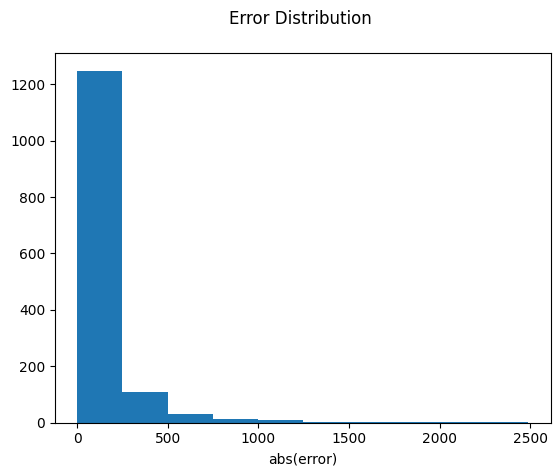

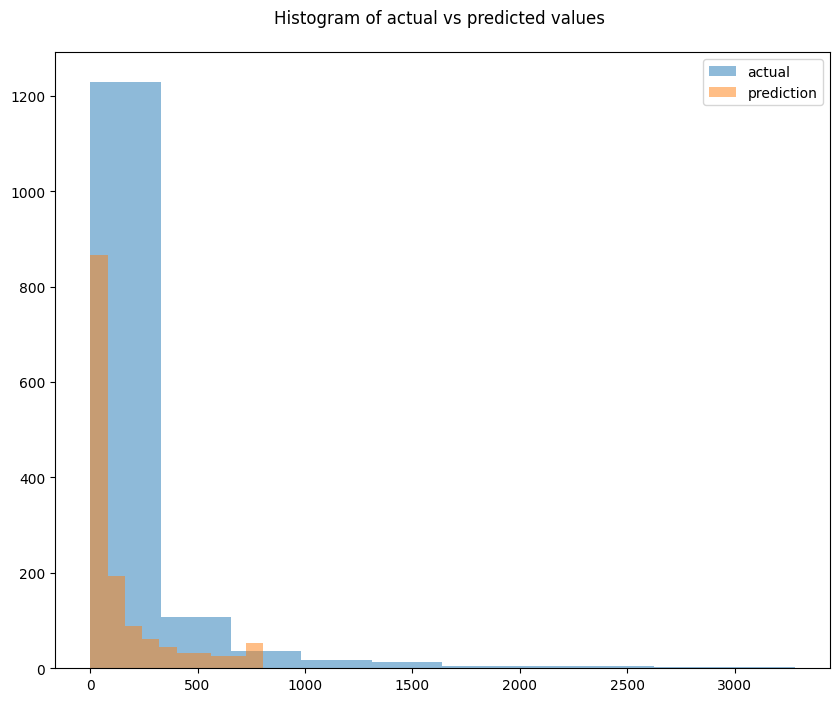

In [10]:
results_test[date_col] = date
results_test['dt_prediction'] = results_test[date_col] + datetime.timedelta(days=15)
results_test['error'] = results_test['actual'] - results_test['prediction']
results_test['abs(error)'] = np.abs(results_test['actual'] - results_test['prediction'])

if model_type == 'mosquito_regression':
    metrics(results_train, results_test, threshold=30)
else:
    metrics(results_train, results_test)
validation_plots(results_test,model_type)

In [11]:
results_train['error'] = results_train['actual'] - results_train['prediction']
results_train['abs(error)'] = np.abs(results_train['actual'] - results_train['prediction'])
results_train = pd.concat([results_train, pd.DataFrame(latent_train)],axis=1)
results_train

,actual,prediction,error,abs(error),0,1,2,3,4
0,23.0,109,-86.0,86.0,-0.024977,-0.359408,0.021366,2.025749,0.054690
1,683.0,723,-40.0,40.0,-1.775549,-0.709072,-1.410935,6.046199,0.279689
2,59.0,68,-9.0,9.0,-0.336908,-1.618444,0.582519,1.266613,0.620556
3,4.0,2,2.0,2.0,7.390010,2.262980,2.618925,-2.467540,2.987081
4,1.0,17,-16.0,16.0,2.936049,-2.245861,1.883069,-1.622899,2.188970
...,...,...,...,...,...,...,...,...,...
5689,18.0,14,4.0,4.0,3.650755,0.969445,2.114506,-0.098630,3.361143
5690,88.0,122,-34.0,34.0,-1.919013,0.278995,-1.006209,2.155130,0.181146
5691,8.0,20,-12.0,12.0,2.335617,1.835927,2.478374,0.257150,2.523723
5692,228.0,140,88.0,88.0,-1.115606,0.860641,-1.037608,2.102077,-1.520619


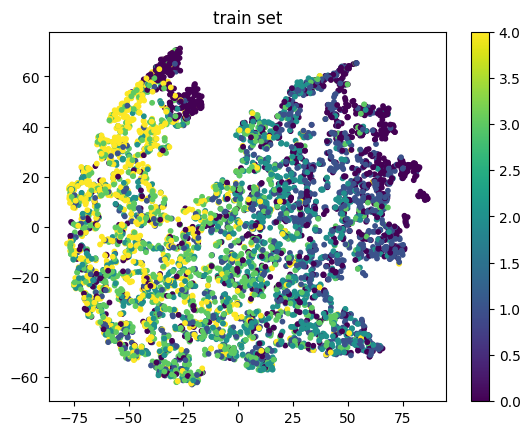

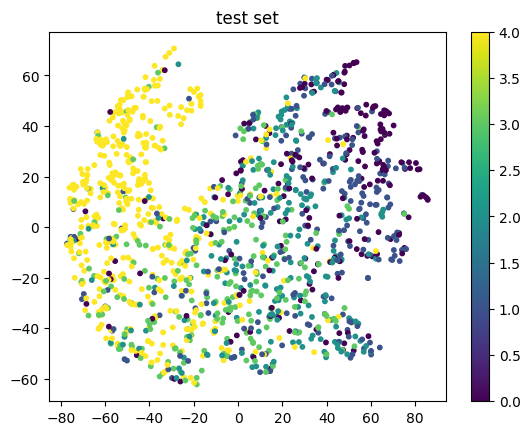

In [12]:
q=5
bins, bounds = pd.qcut(pd.concat([results_train['abs(error)'],results_test['abs(error)']]), retbins=True, q=q, duplicates='drop')

# q=[-1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 600]
# bins, bounds = pd.cut(pd.concat([results_train['abs(error)'],results_test['abs(error)']]), bins=q, retbins=True, labels=classes)

bins = bins.cat.codes
latent = np.concatenate((latent_train, latent_test))
colour_dots = pd.concat([results_train['abs(error)'], results_test['abs(error)']])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(latent)
X1_tsne = X_tsne[:latent_train.shape[0],:]
X2_tsne = X_tsne[latent_train.shape[0]:,:]

# Visualize the t-SNE result
plt.scatter(X1_tsne[:, 0], X1_tsne[:, 1], c=bins[:latent_train.shape[0]], s=10)
plt.colorbar()
plt.title('train set')
plt.show()

plt.scatter(X2_tsne[:, 0], X2_tsne[:, 1], c=bins[latent_train.shape[0]:], s=10)
plt.colorbar()
plt.title('test set')
plt.show()

In [13]:
#keep only train observations with error less than MAE
results_good = results_train.loc[results_train['abs(error)']<results_train['abs(error)'].mean(), 0:].reset_index(drop=True)
results_good

,0,1,2,3,4
0,-0.336908,-1.618444,0.582519,1.266613,0.620556
1,7.390010,2.262980,2.618925,-2.467540,2.987081
2,2.936049,-2.245861,1.883069,-1.622899,2.188970
3,-2.132288,0.434800,-1.341707,4.854761,-0.836637
4,7.416181,-0.848898,-0.455465,-2.328748,3.461834
...,...,...,...,...,...
3909,-1.312854,0.228483,-1.255973,3.610456,-0.201954
3910,0.844262,-0.639405,0.141008,0.028686,-0.938519
3911,3.650755,0.969445,2.114506,-0.098630,3.361143
3912,-1.919013,0.278995,-1.006209,2.155130,0.181146


In [14]:
percentage =0.2

In [15]:
euc_M_dist = eucleidian(np.array(results_good), latent_test, 3)
results_test['dist'] = euc_M_dist
results_test_latent = results_test.sort_values(by=['dist','abs(error)']).reset_index(drop=True)
print('correlation:', results_test_latent.corr().loc['abs(error)','dist'])
print("good:", results_test_latent.iloc[:round(len(results_test_latent)*percentage)]['abs(error)'].mean())
print("bad:", results_test_latent.iloc[-round(len(results_test_latent)*percentage):]['abs(error)'].mean())

correlation: -0.12960398978986384
good: 193.4140350877193
bad: 53.656140350877195


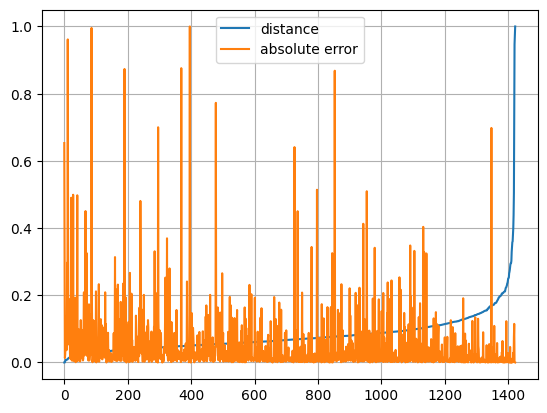

In [16]:
distance = (results_test_latent['dist'] - results_test_latent['dist'].min())/(results_test_latent['dist'].max()-results_test_latent['dist'].min())
error=(results_test_latent['abs(error)']-results_test_latent['abs(error)'].min())/(results_test_latent['abs(error)'].max()-results_test_latent['abs(error)'].min())
plt.plot(distance, label='distance')
plt.plot(error, label='absolute error')
plt.legend()
plt.grid()
plt.show()

In [17]:
results_good = results_train.loc[results_train['abs(error)']<results_train['abs(error)'].mean()].index
results_good = train_X[0][results_good,:]

euc_M_dist = eucleidian(results_good, test_X[0], 3)
results_test['dist'] = euc_M_dist
results_test.corr()
results_test_fs = results_test.sort_values(by=['dist','abs(error)']).reset_index(drop=True)
print('correlation:', results_test_fs.corr().loc['abs(error)','dist'])
print("good:", results_test_fs.iloc[:round(len(results_test_fs)*percentage)][ 'abs(error)'].mean())
print("bad:", results_test_fs.iloc[-round(len(results_test_fs)*percentage):]['abs(error)'].mean())

correlation: -0.004292151895154316
good: 110.35087719298245
bad: 117.9298245614035


In [18]:
results_good = results_train.loc[results_train['abs(error)']<results_train['abs(error)'].mean()].index
results_good = train.loc[results_good,['x','y']]

euc_M_dist = eucleidian(np.array(results_good.drop_duplicates().reset_index(drop=True)), np.array(test[['x','y']]), 3)
results_test['dist'] = euc_M_dist
results_test.corr()
results_test_coord = results_test.sort_values(by=['dist','abs(error)']).reset_index(drop=True)
print('correlation:', results_test_coord.corr().loc['abs(error)','dist'])
print("good:", results_test_coord.iloc[:round(len(results_test_coord)*percentage)]['abs(error)'].mean())
print("bad:", results_test_coord.iloc[-round(len(results_test_coord)*percentage):]['abs(error)'].mean())

correlation: -0.043958568223735645
good: 102.66666666666667
bad: 74.90877192982457
